In [2]:
# Import needed libraries 
import pandas as pd 
import os
from datetime import timedelta
import numpy as np 
from scipy.signal import argrelextrema
import alpaca_trade_api as tradeapi 
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
from mplfinance.original_flavor import candlestick_ohlc

In [3]:
#Load .env environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Set Alpaca API key and secret
APCA_API_KEY_ID = os.getenv("APCA_API_KEY")
APCA_API_SECRET_KEY = os.getenv("APCA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")

#ensuring api keys are correct 
#print(os.getenv("APCA_API_KEY_ID"))
#print(os.getenv("APCA_API_SECRET_KEY"))
#print(os.getenv("ALPACA_ENDPOINT_KEY"))

# Create the Alpaca API object
api = tradeapi.REST(APCA_API_KEY_ID, APCA_API_SECRET_KEY, api_version="v2",base_url= ALPACA_ENDPOINT_KEY)

In [5]:
# Set the ticker
ticker = "QQQ"

# Set timeframe to "1 Minute"
timeframe = "1Min"

# Set start and end datetimes of 3 years from Today
start_date = pd.Timestamp("2021-01-22", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-01-23", tz="America/New_York").isoformat()

# Get 3 years worth of historical data for TSLA
ticker_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
).df

display(ticker_data.head())
display(ticker_data.tail())

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-22 09:00:00+00:00,325.21,325.21,325.21,2,325.21,116,325.216897
2021-01-22 09:01:00+00:00,325.15,325.21,325.15,8,325.21,584,325.180240
2021-01-22 09:02:00+00:00,325.17,325.17,325.17,4,325.17,202,325.170149
2021-01-22 09:03:00+00:00,325.11,325.15,325.09,5,325.09,1200,325.113333
2021-01-22 09:04:00+00:00,325.12,325.19,325.10,27,325.10,4518,325.152262


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-22 22:46:00+00:00,325.32,325.42,325.32,16,325.42,50379,325.419462
2021-01-22 22:51:00+00:00,325.40,325.40,325.30,33,325.33,6151,325.336472
2021-01-22 22:53:00+00:00,325.40,325.40,325.39,14,325.39,2488,325.396612
2021-01-22 22:54:00+00:00,325.40,325.40,325.40,11,325.40,936,325.397970
2021-01-22 22:58:00+00:00,325.40,325.40,325.40,10,325.40,1660,325.400000


In [6]:
#dropping trade_count and vwap column
updated_ticker_data = ticker_data.drop(columns=['trade_count', 'vwap'])

#checking results
updated_ticker_data

,close,high,low,open,volume
timestamp,,,,,
2021-01-22 09:00:00+00:00,325.21,325.21,325.21,325.21,116
2021-01-22 09:01:00+00:00,325.15,325.21,325.15,325.21,584
2021-01-22 09:02:00+00:00,325.17,325.17,325.17,325.17,202
2021-01-22 09:03:00+00:00,325.11,325.15,325.09,325.09,1200
2021-01-22 09:04:00+00:00,325.12,325.19,325.10,325.10,4518
...,...,...,...,...,...
2021-01-22 22:46:00+00:00,325.32,325.42,325.32,325.42,50379
2021-01-22 22:51:00+00:00,325.40,325.40,325.30,325.33,6151
2021-01-22 22:53:00+00:00,325.40,325.40,325.39,325.39,2488


In [27]:
# Convert the index to datetime
updated_ticker_data.index = pd.to_datetime(updated_ticker_data.index)

/Users/Donya/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/Donya/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/Donya/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


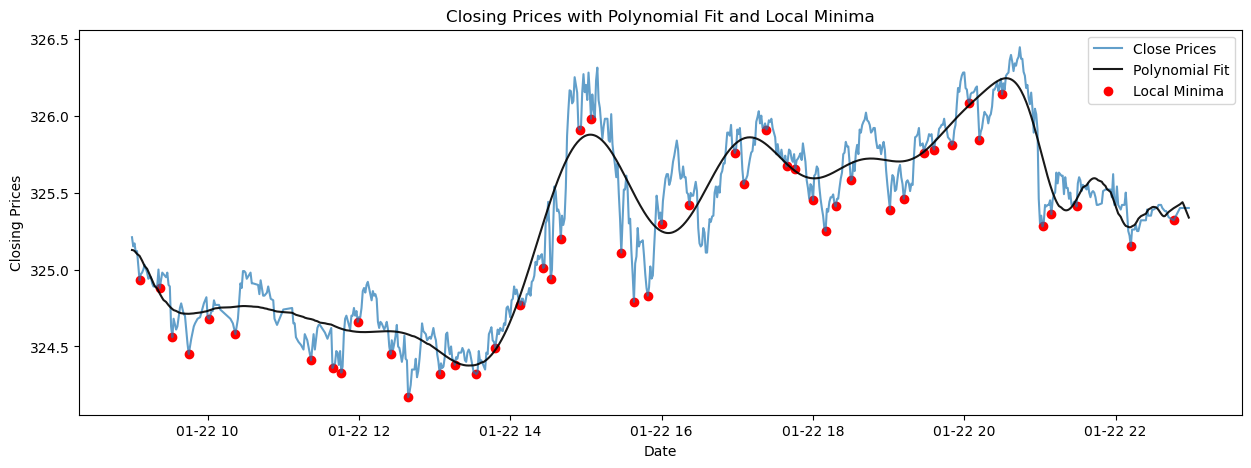

In [33]:
# Plot the stock data, polynomial fit, and local minima
plt.figure(figsize=(15, 5))

# Plot the close prices
min_length = min(len(updated_ticker_data.index), len(updated_ticker_data['close']))
plt.plot(updated_ticker_data.index[:min_length], updated_ticker_data['close'][:min_length], label='Close Prices', alpha=0.7)

# Polynomial fit
x_data = np.arange(min_length)
polynomial_degree = 100  # Adjust as needed
polynomial_coefficients = np.polyfit(x_data, updated_ticker_data['close'][:min_length], polynomial_degree)
y_polynomial = np.polyval(polynomial_coefficients, x_data)

# Plot the polynomial fit
plt.plot(updated_ticker_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# Find local minima indices using scipy's argrelextrema
minima_indices = argrelextrema(updated_ticker_data['close'].values[:min_length], np.less, order=5)[0]

# Plot red dots at local minima
plt.scatter(updated_ticker_data.index[minima_indices], updated_ticker_data['close'].iloc[minima_indices], color='red', label='Local Minima')

plt.title('Closing Prices with Polynomial Fit and Local Minima')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

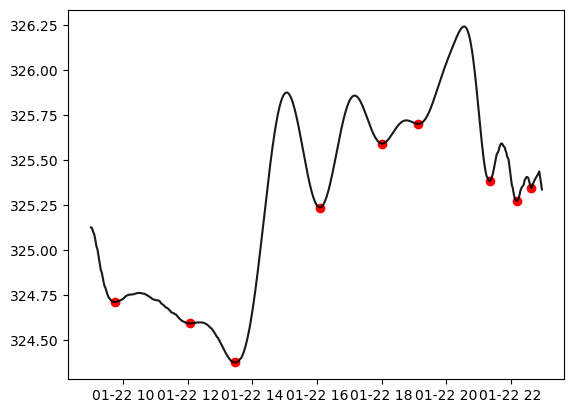

In [40]:
local_poly_minima = argrelextrema(y_polynomial, np.less, order=5)[0]

# Plot polynomial fit
plt.plot(updated_ticker_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# Plot red dots at local minima
plt.scatter(updated_ticker_data.index[local_poly_minima], y_polynomial[local_poly_minima], color='red', label='Local Minima')


/Users/Donya/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/Donya/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/Donya/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


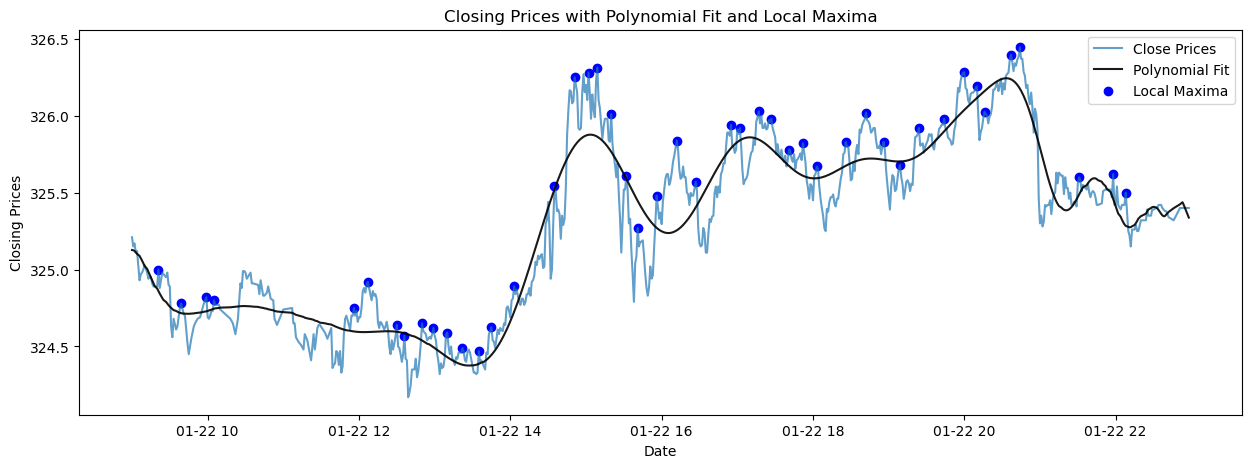

In [16]:
# Plot the stock data, polynomial fit, and local minima and maxima
plt.figure(figsize=(15, 5))

# Plot the close prices
min_length = min(len(updated_ticker_data.index), len(updated_ticker_data['close']))
plt.plot(updated_ticker_data.index[:min_length], updated_ticker_data['close'][:min_length], label='Close Prices', alpha=0.7)

# Polynomial fit
x_data = np.arange(min_length)
polynomial_degree = 100  # Adjust as needed
polynomial_coefficients = np.polyfit(x_data, updated_ticker_data['close'][:min_length], polynomial_degree)
y_polynomial = np.polyval(polynomial_coefficients, x_data)

# Plot the polynomial fit
plt.plot(updated_ticker_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# Find local maxima indices using scipy's argrelextrema
maxima_indices = argrelextrema(updated_ticker_data['close'].values[:min_length], np.greater, order=5)[0]

# Plot blue dots at local maxima
plt.scatter(updated_ticker_data.index[maxima_indices], updated_ticker_data['close'].iloc[maxima_indices], color='blue', label='Local Maxima')

plt.title('Closing Prices with Polynomial Fit and Local Maxima')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()


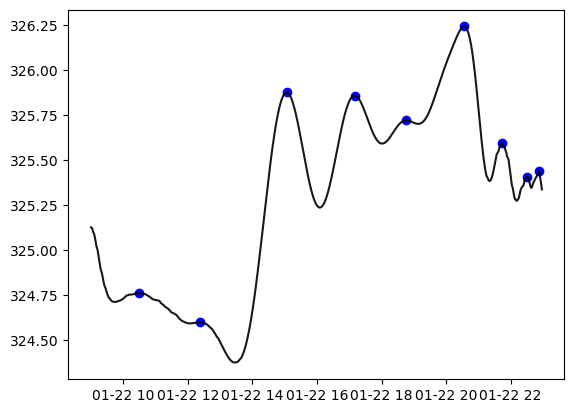

In [44]:
local_poly_maxima = argrelextrema(y_polynomial, np.greater, order=5)[0]

# Plot polynomial fit
plt.plot(updated_ticker_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

plt.scatter(updated_ticker_data.index[local_poly_maxima],y_polynomial[local_poly_maxima], color="blue", label = "Local Maxima")